In [23]:
import os

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import torch
import tqdm

from mining import estimate, datasets

In [10]:
def plot(
    X,
    y,
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
):
    x_start = torch.min(X) - 0.1 * (torch.max(X) - torch.min(X))
    x_end = torch.max(X) + 0.1 * (torch.max(X) - torch.min(X))
    artists = []
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        observed_data_artists = ax.plot(X.numpy(), y.numpy(), "kx")
        artists.extend(observed_data_artists)
    if plot_predictions:
        Xtest = torch.linspace(x_start, x_end, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP or type(model) == gp.models.VariationalGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        predictions_artists = ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        artists.extend(predictions_artists)
        fill_artist = ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
        artists.append(fill_artist)
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(x_start, x_end, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) not in [gp.models.VariationalSparseGP, gp.models.VariationalGP]
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        samples_artist = ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)
        artists.append(samples_artist)

    ax.set_xlim(x_start, x_end)
    return artists


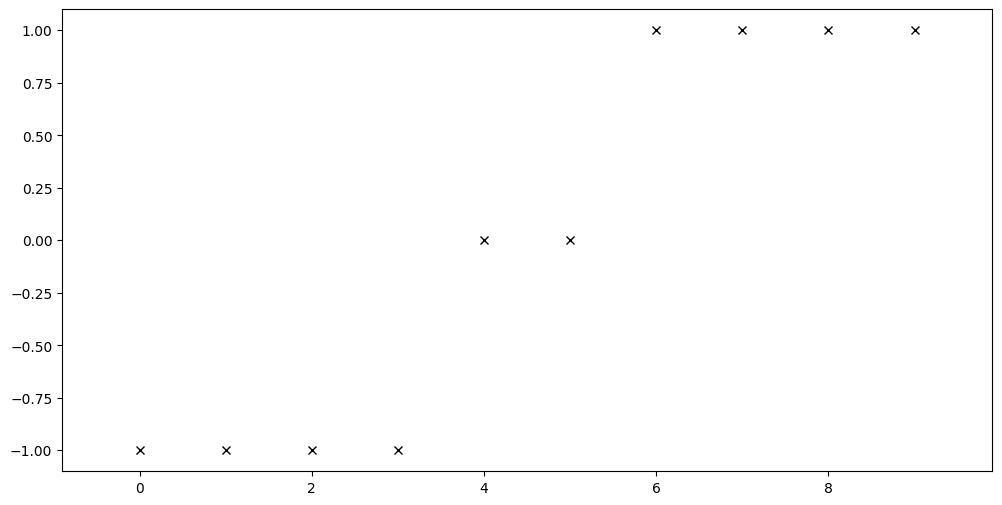

In [28]:
num_data_points = 10
user_stance = np.linspace(-1, 1, num_data_points)
user_stance_variance = 0.1
predict_profile = 'perfect'
dataset = datasets.SimpleGenerativeOpinionTimelineDataset(user_stance, user_stance_variance, num_data_points, pred_profile_type=predict_profile, halflife=10.)
opinion_sequences, users, classifier_indices = dataset.get_data(start=0, end=dataset.max_time_step)
estimator = estimate.StanceEstimation(dataset.all_classifier_profiles)
estimator.set_stance(dataset.stance_columns[0])
X = torch.tensor(np.arange(0, num_data_points)).float().view((-1,))
y = torch.tensor(opinion_sequences[0, :, 0]).float().view((-1,))
plot(X, y, plot_observed_data=True)

In [32]:
kernel = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(0.1), lengthscale=torch.tensor(2)
)
# likelihood = gp.likelihoods.MultiClass(num_classes=3)#, response_function=predictor_probs)
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(0.5))

[[<matplotlib.lines.Line2D at 0x7b78cedcd8d0>,

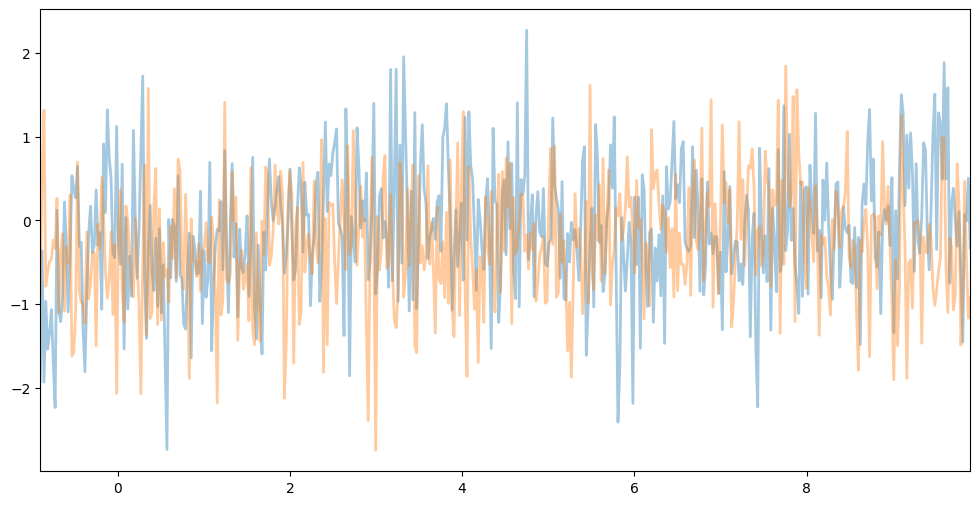

In [21]:
plot(X, y, model=gpr, kernel=kernel, n_prior_samples=2)

In [33]:
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
variances = []
lengthscales = []
noises = []
num_steps = 2000
for i in tqdm.tqdm(range(num_steps)):
    variances.append(gpr.kernel.variance.item())
    noises.append(gpr.noise.item())
    lengthscales.append(gpr.kernel.lengthscale.item())
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

100%|██████████| 2000/2000 [00:06<00:00, 304.95it/s]


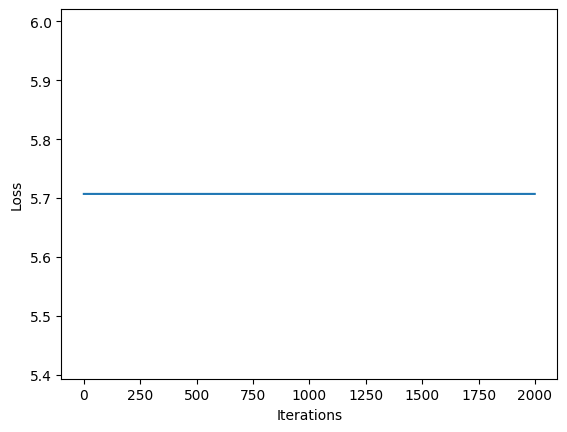

In [34]:
# let's plot the loss curve after 2000 steps of training
def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text


plot_loss(losses)

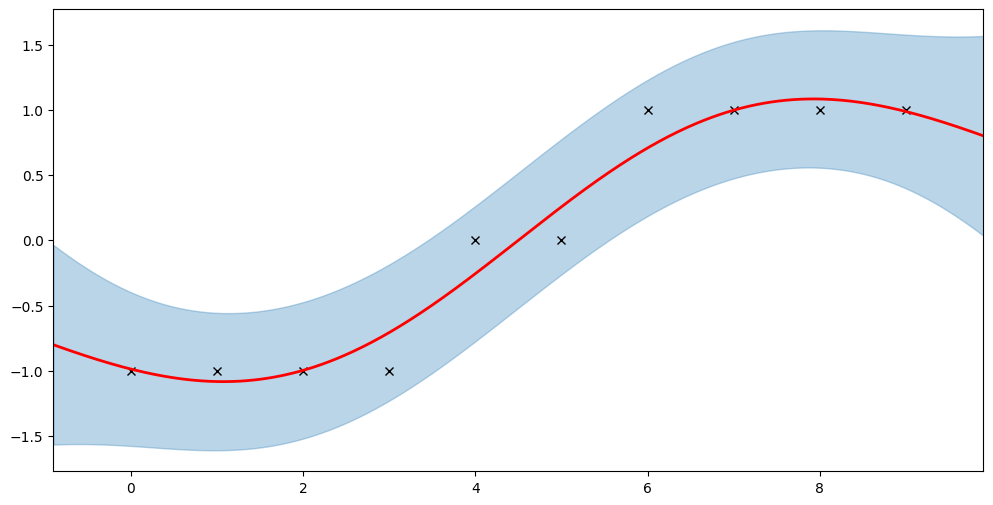

In [35]:
plot(X, y, model=gpr, plot_observed_data=True, plot_predictions=True)